# Paper Replicating

## 0.Get Setup

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 4356 (delta 213), reused 254 (delta 178), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 31.92 MiB/s, done.
Resolving deltas: 100% (2585/2585), done.
Updating files: 100% (248/248), done.


In [ ]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1.Get Data

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2.Create Datasets and DataLoaders

### 2.1 Create Transforms

In [ ]:
from going_modular.going_modular import data_setup
from torchvision import transforms

# Create image size
IMG_SIZE = 224

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

### 2.2 Create dataloaders

In [ ]:
# Create a batch size of 32
# Paper uses 4096 , our hardware cant handle
# Later can be upgraded

BATCH_SIZE = 32

# create dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

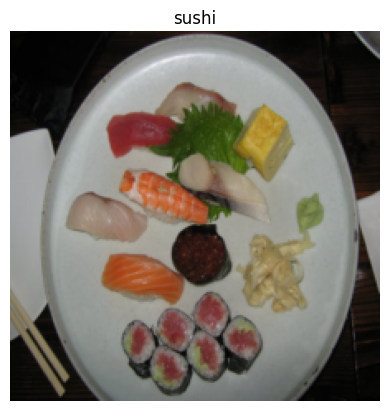

In [ ]:
# Plot the image
import matplotlib.pyplot as plt

# Channels at the end
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

## 3.Replicating ViT : Overview

## 4.Equation 1: Split data into patches and creating the class, position and patch embedding

### 4.1 Calculating patch embedding input and output shapes by hand

In [ ]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate number of patches
number_of_patches = int((height * width )/ (patch_size **2))
number_of_patches

196

In [ ]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
print(f"Input shape (single 2D image ): {embedding_layer_input_shape}")
print(f"Output Shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image ): (224, 224, 3)
Output Shape (single 1D sequence of patches): (196, 768)


### 4.2 Turning a single image into patches

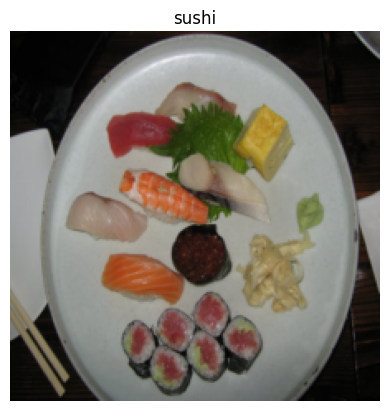

In [ ]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

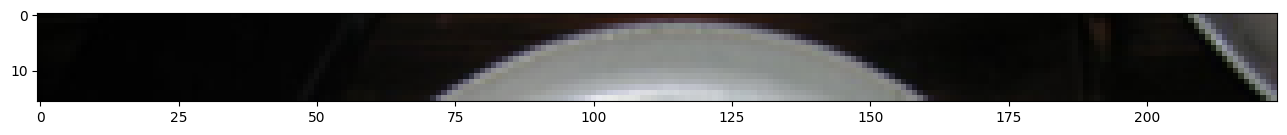

In [ ]:
# get the top row of the image
# Convert to H * W  * C
image_permuted = image.permute(1,2,0)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize = (patch_size , patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


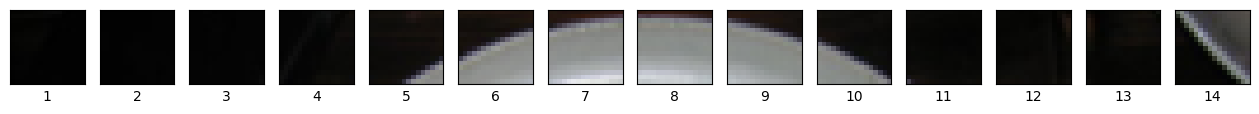

In [ ]:
# Setup code to plot top row as patches
img_size = 224
patch_size =  16
num_patches = img_size / patch_size
# image size must be divisible by patch size
assert img_size % patch_size == 0
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")



# create a series of subplots
fig, axs = plt.subplots(
    nrows = 1,
    ncols = img_size // patch_size,  # One column per patch
    sharex = True,
    sharey = True,
    figsize = (patch_size, patch_size)
)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


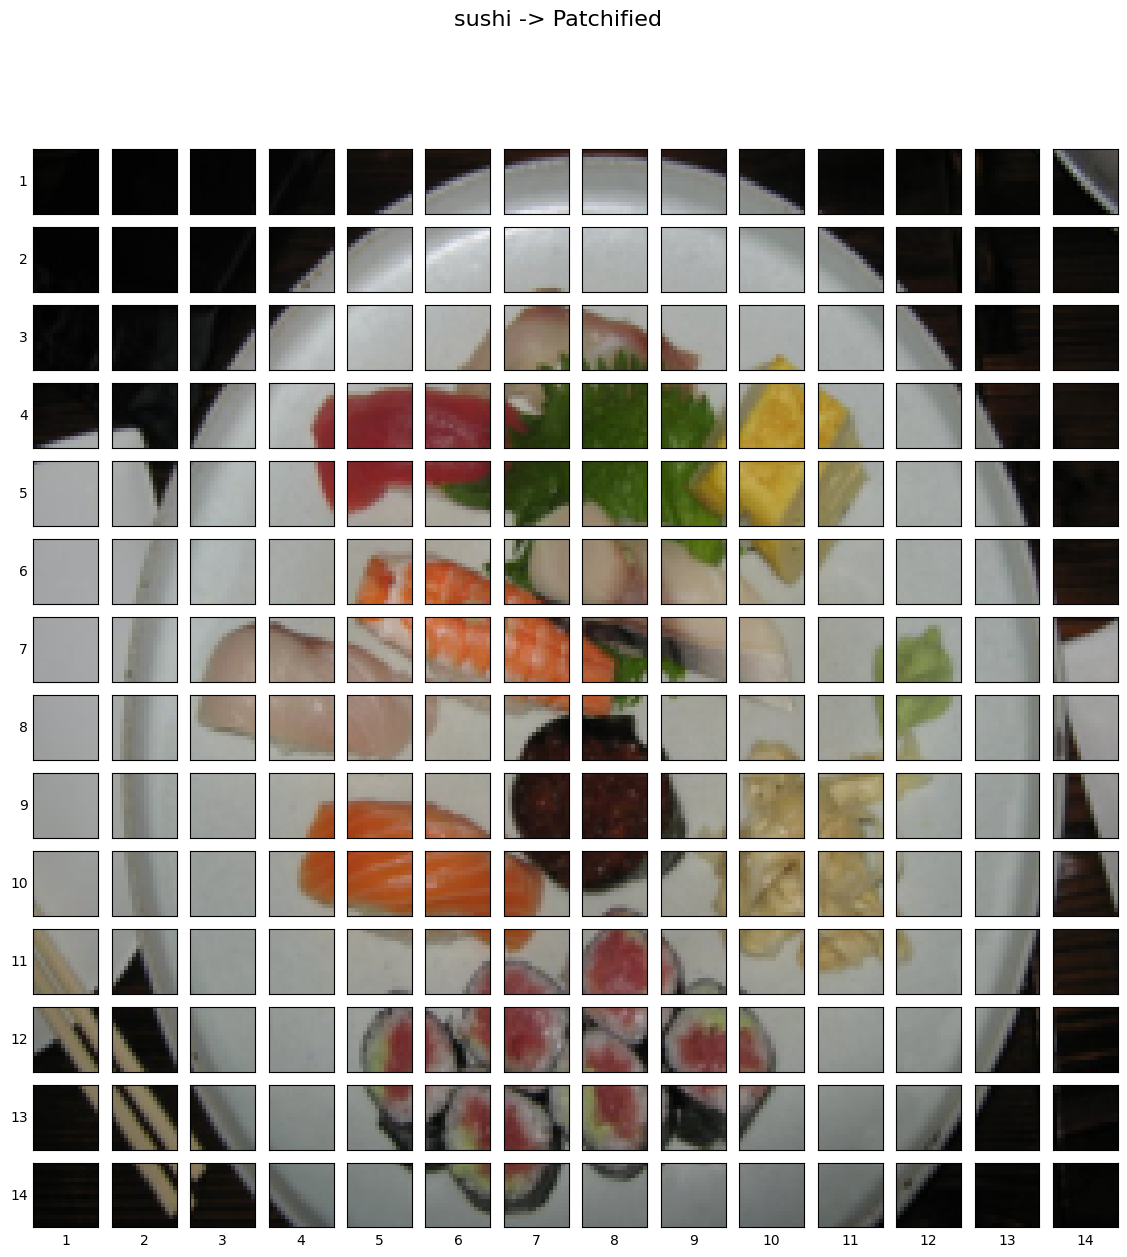

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### 4.3 Creating image patches and turning them into patch embeddings

In [ ]:
# Create conv2d layer to turn image into patches of learnable feature params

from torch import nn

# set the patch size
patch_size = 16

# create a conv2d layers
conv2d = nn.Conv2d(
    in_channels = 3,
    out_channels = 768,
    kernel_size = patch_size,
    stride = patch_size,
    padding = 0
)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

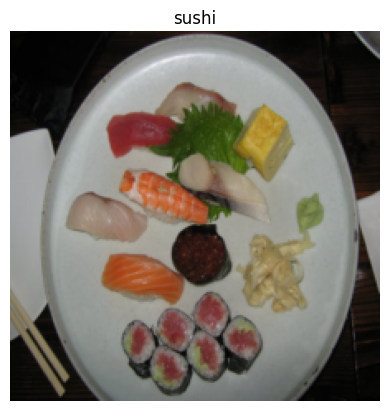

In [ ]:
# view a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [ ]:
# pass the image through conv2d

# Add batch dimension
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [301, 224, 598, 670, 167]


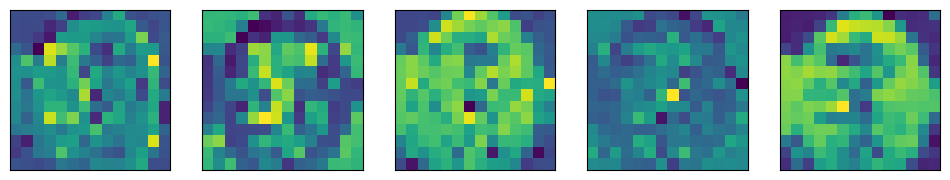

In [ ]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [ ]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.0143,  0.0161,  0.0190,  0.0259,  0.0385,  0.1806,  0.2676,
            0.2288,  0.1545,  0.1641,  0.0212,  0.0301,  0.0162,  0.0797],
          [ 0.0175,  0.0154,  0.0227,  0.1599,  0.2235,  0.1671,  0.1175,
            0.0911,  0.1135,  0.1362,  0.1307,  0.0421,  0.0257,  0.0360],
          [ 0.0239,  0.0241,  0.0769,  0.1909,  0.0885,  0.0987,  0.1301,
            0.0288,  0.0522,  0.1212,  0.1162,  0.0324,  0.0360,  0.0311],
          [ 0.1135,  0.0422,  0.3404,  0.0026,  0.0339,  0.0648, -0.0806,
            0.1069,  0.0924,  0.1975,  0.1852,  0.0798,  0.0602,  0.0292],
          [ 0.1154,  0.0482,  0.1605,  0.1341,  0.3502,  0.2550,  0.1284,
            0.1257,  0.1438,  0.2255,  0.2348,  0.1115, -0.0249,  0.0206],
          [ 0.1141,  0.0839,  0.1047,  0.1088, -0.0196,  0.0935,  0.1476,
            0.0725,  0.2243,  0.1790,  0.1587,  0.1176,  0.1215,  0.0301],
          [ 0.1167,  0.1418,  0.0583,  0.1199,  0.1243,  0.2317,  0.2008,
            0.1188,  0.1507,  0.

### 4.4 Flattening the patch embedding with torch.nn.Flatten()

In [ ]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [ ]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


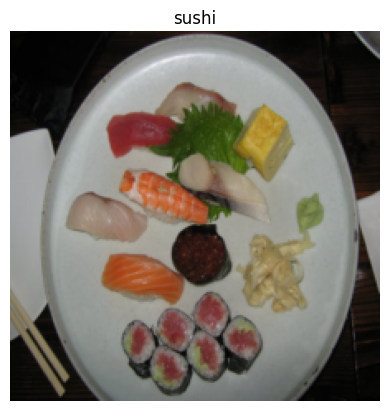

In [ ]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [ ]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


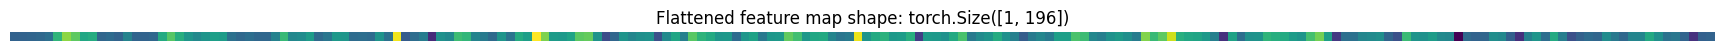

In [ ]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [ ]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 0.0143,  0.0161,  0.0190,  0.0259,  0.0385,  0.1806,  0.2676,  0.2288,
           0.1545,  0.1641,  0.0212,  0.0301,  0.0162,  0.0797,  0.0175,  0.0154,
           0.0227,  0.1599,  0.2235,  0.1671,  0.1175,  0.0911,  0.1135,  0.1362,
           0.1307,  0.0421,  0.0257,  0.0360,  0.0239,  0.0241,  0.0769,  0.1909,
           0.0885,  0.0987,  0.1301,  0.0288,  0.0522,  0.1212,  0.1162,  0.0324,
           0.0360,  0.0311,  0.1135,  0.0422,  0.3404,  0.0026,  0.0339,  0.0648,
          -0.0806,  0.1069,  0.0924,  0.1975,  0.1852,  0.0798,  0.0602,  0.0292,
           0.1154,  0.0482,  0.1605,  0.1341,  0.3502,  0.2550,  0.1284,  0.1257,
           0.1438,  0.2255,  0.2348,  0.1115, -0.0249,  0.0206,  0.1141,  0.0839,
           0.1047,  0.1088, -0.0196,  0.0935,  0.1476,  0.0725,  0.2243,  0.1790,
           0.1587,  0.1176,  0.1215,  0.0301,  0.1167,  0.1418,  0.0583,  0.1199,
           0.1243,  0.2317,  0.2008,  0.1188,  0.1507,  0.1577,  0.0835,  0.0521,
           0.063

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

1. Create a class 'PatchEmbedding'
2. Initialize it with appropriate hyperparameters
3. Create a layer to turn an image in to embedding patches
4. Create a layer to flatten the feature maps of output layer
5. Define forward function for forward computation
6. Make sure output layer reflect the required shape of patch embedding

In [ ]:
# 1. Create a class
class PatchEmbedding(nn.Module):
  # 2. Initialize the layer with appropriate params
  def __init__(self,
               in_channels : int = 3,
               patch_size : int = 16,
               embedding_dim : int = 768
               ):
    super().__init__()
    self.patch_size = patch_size
    # 3. Create layer to turn image into embedidng patches
    self.patcher  = nn.Conv2d(
                              in_channels = in_channels,
                              out_channels = embedding_dim,
                              kernel_size = patch_size,
                              stride = patch_size,
                              padding = 0
                            )

    # 4. Create llayer to flatten the feature maps
    self.flatten = nn.Flatten(start_dim = 2, end_dim = 3)

  # 5. Define a forward method to define the forward computing steps
  def forward(self, x):
    # Create assertion to check that inputs are correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # 6. Make sure the output shape has the right order
    return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [ ]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [ ]:
rand_img_tensor = torch.randn(1,3, 224, 224)
rand_img_tensor_bad = torch.randn(1,3, 250, 250)

#patchify(rand_img_tensor_bad)


AssertionError: Input image size must be divisible by patch size, image shape: 250, patch size: 16

### 4.6 Creating class token embedding

In [ ]:
# get the batch size and embedding dimensions
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

batch_size, embedding_dimension

(1, 768)

In [ ]:
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                                      requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [ ]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [ ]:
# Add the class token embedding to the front of patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim =1) # nunber of patches dimension
# View the patch embedding and patch embedding shape
print(patch_embedded_image_with_class_embedding)
print(f"Patch embedding shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-9.9595e-01,  1.4136e+00,  3.7235e-01,  ..., -7.8786e-01,
           3.6363e-01, -9.1862e-01],
         [-2.6745e-02, -9.6791e-03, -3.3275e-02,  ...,  1.8100e-02,
          -9.7427e-03,  1.3937e-02],
         [-3.1749e-02, -5.8384e-03, -3.5069e-02,  ...,  1.8645e-02,
          -7.7240e-03,  6.0209e-03],
         ...,
         [-6.1044e-04, -9.2814e-02,  1.0447e-02,  ...,  4.6796e-02,
          -1.6161e-01,  1.5430e-01],
         [-4.0386e-02, -5.1402e-03, -3.9343e-02,  ...,  2.8094e-02,
          -2.5645e-02,  7.5974e-03],
         [-4.0560e-02, -4.5477e-03, -3.1839e-02,  ...,  2.6831e-02,
          -2.2064e-02,  1.0647e-02]]], grad_fn=<CatBackward0>)
Patch embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### 4.7 Creating the position embedding

In [ ]:
# View the sequence of patch embedding with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[-9.9595e-01,  1.4136e+00,  3.7235e-01,  ..., -7.8786e-01,
            3.6363e-01, -9.1862e-01],
          [-2.6745e-02, -9.6791e-03, -3.3275e-02,  ...,  1.8100e-02,
           -9.7427e-03,  1.3937e-02],
          [-3.1749e-02, -5.8384e-03, -3.5069e-02,  ...,  1.8645e-02,
           -7.7240e-03,  6.0209e-03],
          ...,
          [-6.1044e-04, -9.2814e-02,  1.0447e-02,  ...,  4.6796e-02,
           -1.6161e-01,  1.5430e-01],
          [-4.0386e-02, -5.1402e-03, -3.9343e-02,  ...,  2.8094e-02,
           -2.5645e-02,  7.5974e-03],
          [-4.0560e-02, -4.5477e-03, -3.1839e-02,  ...,  2.6831e-02,
           -2.2064e-02,  1.0647e-02]]], grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
# calculate the number of patches
number_of_patches = int((height * width )/patch_size**2)

# Get the mebdding dimensions
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [ ]:
# Add position embedding to patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding, patch_and_position_embedding.shape

(tensor([[[0.0041, 2.4136, 1.3723,  ..., 0.2121, 1.3636, 0.0814],
          [0.9733, 0.9903, 0.9667,  ..., 1.0181, 0.9903, 1.0139],
          [0.9683, 0.9942, 0.9649,  ..., 1.0186, 0.9923, 1.0060],
          ...,
          [0.9994, 0.9072, 1.0104,  ..., 1.0468, 0.8384, 1.1543],
          [0.9596, 0.9949, 0.9607,  ..., 1.0281, 0.9744, 1.0076],
          [0.9594, 0.9955, 0.9682,  ..., 1.0268, 0.9779, 1.0106]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"\nPatch embeddings, class token prepended and positional embeddings added shape: \n{patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[0.0041, 2.4136, 1.3723,  ..., 0.2121, 1.3636, 0.0814],
         [0.9733, 0.9903, 0.9667,  ..., 1.0181, 0.9903, 1.0139],
         [0.9683, 0.9942, 0.9649,  ..., 1.0186, 0.9923, 1.0060],
         ...,
         [0.9994, 0.9072, 1.0104,  ..., 1.0468, 0.8384, 1.1543],
         [0.9596, 0.9949, 0.9607,  ..., 1.0281, 0.9744, 1.0076],
         [0.9594, 0.9955, 0.9682,  ..., 1.0268, 0.9779, 1.0106]]],
       grad_fn=<AddBackward0>)

Patch embeddings, class token prepended and positional embeddings added shape: 
torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### 4.8 Putting it all together: from image to embedding

In [ ]:
# Set seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print shapes of original imag tensor and get image dims
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get the image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input Image Shape : {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. PAss input image through ImageEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch Embedding Shape : {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad = True
                           )

print(f"Class Token Embedding Shape : {class_token.shape}")


# 7. Prepend the class token to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim = 1)
print(f"Patch Embedding with class token shape : {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad = True)


# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and Position Embedding shape : {patch_and_position_embedding.shape}")


Image tensor shape: torch.Size([3, 224, 224])
Input Image Shape : torch.Size([1, 3, 224, 224])
Patch Embedding Shape : torch.Size([1, 196, 768])
Class Token Embedding Shape : torch.Size([1, 1, 768])
Patch Embedding with class token shape : torch.Size([1, 197, 768])
Patch and Position Embedding shape : torch.Size([1, 197, 768])


##5.Equation 2: Multi-Head Attention (MSA)

### 5.1 Layer Normalization Layer

**Normalization** - Make data have the same mean and same standard deviation

In [ ]:
class MultiHeadAttentionBlock(nn.Module):
  '''
  Creates a multi-head self attention block.

  '''